In [31]:
import numpy as np

def load_data():
    
    training = {}
    validation = {}
    test = {}

    training['X'] = np.load('./ProcessedData/train/hog_features.npy')
    training['Y'] = np.load('./ProcessedData/train/emotion_classes.npy')
    
    validation['X'] = np.load('./ProcessedData/validate/hog_features.npy')
    validation['Y'] = np.load('./ProcessedData/validate/emotion_classes.npy')
   
    test['X'] = np.load('./ProcessedData/test/hog_features.npy')
    test['Y'] = np.load('./ProcessedData/test/emotion_classes.npy')

    return training, validation, test

In [34]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle

def evaluate(model, X, Y):
        predicted_Y = model.predict(X)
        accuracy = accuracy_score(Y, predicted_Y)
        return accuracy

def train(epochs=10000, random_state=0, kernel='rbf', decision_function='ovr', gamma='auto', training=True):
        training, validation, test = load_data()
        if training:
            model = SVC(random_state=random_state, max_iter=epochs, kernel=kernel, decision_function_shape=decision_function, gamma=gamma)
            model.fit(training['X'], training['Y'])
        
            with open('./model.bin', 'wb') as f:
                pickle.dump(model, f)
            accuracy = evaluate(model, validation['X'], validation['Y'])
            print(accuracy)
            return accuracy
        else:
            with open('./model.bin', 'rb') as f:
                    model = pickle.load(f)
                    
            return evaluate(model, test['X'], test['Y'])

In [35]:
# need to tune params
train()

0.2774968394437421


0.2774968394437421

In [40]:
import time
import pprint
import numpy as np 
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# define the search space
fspace = {
    'decision_function': hp.choice('decision_function', ['ovr', 'ovo']),
    'gamma':  hp.uniform('gamma', 0.00011, 0.001),
}

max_evals = 15
current_eval = 1
train_history = []

def function_to_minimize(hyperparams, gamma='auto', decision_function='ovr'):
    decision_function = hyperparams['decision_function']
    gamma = hyperparams['gamma']
    global current_eval 
    global max_evals
    print( "#################################")
    print( "       Evaluation {} of {}".format(current_eval, max_evals))
    print( "#################################")
    start_time = time.time()
    try:
        accuracy = train(epochs=10000, decision_function=decision_function, gamma=gamma)
        training_time = int(round(time.time() - start_time))
        current_eval += 1
        train_history.append({'accuracy':accuracy, 'decision_function':decision_function, 'gamma':gamma, 'time':training_time})
    except Exception as e:
        print( "#################################")
        print( "Exception during training: {}".format(str(e)))
        print( "Saving train history in train_history.npy")
        np.save("train_history.npy", train_history)
        exit()
    return {'loss': -accuracy, 'time': training_time, 'status': STATUS_OK}

# lunch the hyperparameters search
trials = Trials()
best_trial = fmin(fn=function_to_minimize, space=fspace, algo=tpe.suggest, max_evals=max_evals, trials=trials)

# get some additional information and print( the best parameters
for trial in trials.trials:
    if trial['misc']['vals']['decision_function'][0] == best_trial['decision_function'] and \
            trial['misc']['vals']['gamma'][0] == best_trial['gamma']:
        best_trial['accuracy'] = -trial['result']['loss'] * 100
        best_trial['time'] = trial['result']['time']
print( "#################################")
print( "      Best parameters found")
print( "#################################")
pprint.pprint(best_trial)
print( "decision_function { 0: ovr, 1: ovo }")
print( "#################################")

#################################                     
       Evaluation 1 of 15                             
#################################                     
0.2661188369152971                                    
#################################                                                
       Evaluation 2 of 15                                                        
#################################                                                
0.2661188369152971                                                               
#################################                                                
       Evaluation 3 of 15                                                        
#################################                                                
0.2661188369152971                                                               
#################################                                                
       Evaluation 4 of 15                 

In [90]:
with open('./model.bin', 'rb') as f:
    model = pickle.load(f)
    
evaluate(model, test['X'], test['Y'])

0.24812030075187969

In [94]:
import pandas as pd 

training = pd.read_csv('../Data/training.csv', usecols=["emotion", "image"," pixels"])
validation = pd.read_csv('../Data/validation.csv', usecols=["emotion", "image"," pixels"])
testing = pd.read_csv('../Data/test.csv', usecols=["emotion", "image"," pixels"])

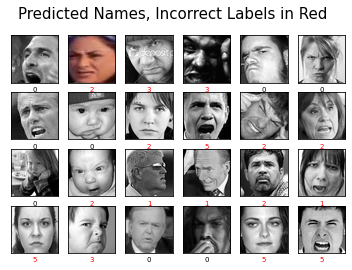

In [89]:
import matplotlib.pyplot as plt
from matplotlib import image
import cv2

training, validation, test = load_data()
target_names=["0","1","2","3","4","5","6"]

with open('./model.bin', 'rb') as f:
    model = pickle.load(f)
yfit = model.predict(test["X"])

fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    img_pixels = testing.iloc[i][" pixels"]
        
    # if images are jpg 
    if type(img_pixels) is float:
        imgpath = '../Data/MuxspaceDataset/images/'
        img_pixels = image.imread(imgpath + str(testing.iloc[i]["image"]))   # load image as pixel array
        img_data = cv2.resize(img_pixels, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)

    # if images are pixels
    else:
        img_pixels = testing.iloc[i][" pixels"]
        img_string = img_pixels.split(' ')
        img_data = np.asarray(img_string, dtype=np.uint8).reshape(48, 48)

    axi.imshow(img_data, cmap=plt.cm.gray)
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(target_names[yfit[i]], color='black' if yfit[i] == test["Y"][i] else 'red', fontsize=7)
fig.suptitle('Predicted Names, Incorrect Labels in Red', size=15);

In [93]:
from sklearn.metrics import classification_report
target_names_1=["0-Angry","1-Disgust","2-Fear","3-Happy","4-Sad","5-Surprise","6-Neutral"]
print(classification_report(test["Y"], yfit,
                            target_names=target_names_1))

              precision    recall  f1-score   support

     0-Angry       0.21      0.28      0.24       228
   1-Disgust       0.26      0.23      0.24       228
      2-Fear       0.17      0.11      0.13       228
     3-Happy       0.23      0.29      0.25       228
       4-Sad       0.31      0.12      0.18       228
  5-Surprise       0.34      0.32      0.33       228
   6-Neutral       0.26      0.39      0.31       228

    accuracy                           0.25      1596
   macro avg       0.25      0.25      0.24      1596
weighted avg       0.25      0.25      0.24      1596



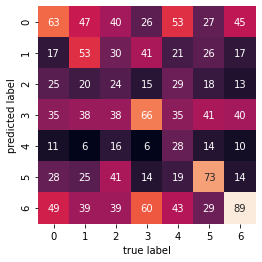

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(test["Y"], yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');